In [ ]:
# Essentials
import numpy as np 
import pandas as pd 
import tables
from functools import partial

# For Ploting
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from IPython.display import HTML
%matplotlib inline
from rasterio import rio
from rasterio.plot import show

# For Scipy
from scipy import interp
from scipy.stats import wilcoxon, mannwhitneyu, friedmanchisquare, ttest_ind

# For Sci-Kit Learn
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

from sklearn.model_selection import cross_validate, cross_val_score,cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, log_loss, make_scorer, auc, roc_curve,brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import random

# For HyperOpt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, rand, space_eval
from hyperopt.pyll import scope as hp_scope
from hyperopt.pyll.stochastic import sample as ho_sample

# OS Specific
from pathlib import Path
import time

# Geo-Data
import geopandas as gpd 
from shapely.geometry import Point
import rasterio as rio
from osgeo import gdal,ogr



#For Markdown
from tabulate import tabulate
import fiona
import pyspatialml as pml

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install pyspatialml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 99.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.9 MB/s 
     |████████████████████████████████| 16.6 MB 43 kB/s 
     |████████████████████████████████| 7.8 MB 47.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 10.2 MB/s 


In [ ]:
# Load Input Data
def load_data(data):
    try:
        df = pd.read_csv(data)
        return df
    except IOError:
        print("IOError: The file is not available...Check if it exist!")


# Dataset Path
data_path = "/content/drive/MyDrive/FINAL_RESEARCH_DATA/originaldata.csv"
input_df = load_data(data_path)
input_df=input_df.fillna(0) 


In [ ]:
# Number of CPUs to use in Optimization
cpus = 2

# Set the RandomState of the seed:
seed = 101
rng = np.random.RandomState(seed)
np.random.seed(seed)         
print ("Random number with seed 30")
random.seed(seed)

Random number with seed 30


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


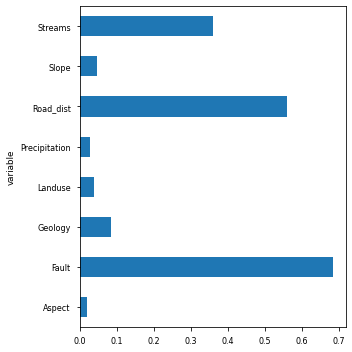

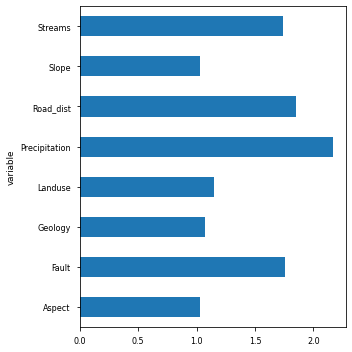

In [ ]:
# Compute the correlation matrix
input_cor = input_df.drop("Y", axis=1).corr()
# Compute info-Gain
gain_df = {"variable":input_df.drop("Y", axis=1).columns,
                        "gain":mutual_info_classif(input_df.drop("Y", axis=1), input_df["Y"], discrete_features=True)}
gain_df = pd.DataFrame(data=gain_df)
with open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/gain_df.md",'w') as tabl:
  print(tabulate(gain_df, headers=['variable', 'gain'],tablefmt="grid"),file=tabl)

plt.style.use("seaborn-paper")
fig, ax = plt.subplots(figsize=(5,5))
gain_df.plot.barh(x="variable",y="gain",ax=ax,legend=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/FINAL_RESEARCH_DATA/gain_plot.jpg',quality=100, dpi=300,bbox_inchs="tight")

# Compute the VIF
vifs = pd.DataFrame(data={"vif":np.linalg.inv(input_cor.values).diagonal(),"variable":input_cor.index})
# vifs = pd.Series(np.linalg.inv(input_cor.values).diagonal(), index=input_cor.index)
# vifs.astype("float")
with open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/vif_df.md",'w') as tabl:
    print(tabulate(vifs, headers=['variable', 'vif'],tablefmt="grid"),file=tabl)

plt.style.use("seaborn-paper")
fig, ax = plt.subplots(figsize=(5,5))
vifs.plot.barh(x="variable",y="vif",ax=ax,legend=False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/FINAL_RESEARCH_DATA/vif_plot.jpg',quality=100, dpi=300,bbox_inchs="tight")


In [ ]:
# Init. the splitting function:
def cv_splitting(features, labels, cv, inner_cv=None):
    '''
    0 Refer to Features
    1 Refer to Labels
    '''
    X_train_out = []
    Y_train_out = []
    X_test_out = []
    Y_test_out = []
    print("Splitting the Input data according to The resampling...")
    for i, (train_idx, test_idx) in enumerate(cv.split(features, labels)):
        print("Fold number %d...." % (i), end=" ")
        X_train_out.append(features[train_idx])
        Y_train_out.append(labels[train_idx])
        X_test_out.append(features[test_idx])
        Y_test_out.append(labels[test_idx])
        print("done.")
    return X_train_out,Y_train_out,X_test_out,Y_test_out
 

In [ ]:
# Init. Misc settings
# Setup the desired resampling Stratigy With 10 CV as Nested Inner Sampling
X_Data = input_df.drop(["Y"],axis=1,inplace=False).values
Y_Data = input_df["Y"].values               
inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
# Split the Input data acooring the resampling strategy
X_train_out,Y_train_out,X_test_out,Y_test_out = cv_splitting(X_Data, Y_Data, outer_cv)
# Evaluation metrics
score_metrics = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),
                "Kappa":make_scorer(cohen_kappa_score)
                # "Logloss":make_scorer(log_loss,greater_is_better=False)
                }


Splitting the Input data according to The resampling...
Fold number 0.... done.
Fold number 1.... done.
Fold number 2.... done.
Fold number 3.... done.
Fold number 4.... done.


In [ ]:
# Setting up the objective function
count = 0
def objective_func(params,xdata, clf, ydata, cv_resample,metric="roc_auc"):
    global count
    count += 1
    lrn_clf = clf
    lrn_clf = lrn_clf.set_params(**params)
    obj_scores = []
    for i, (X, Y) in enumerate(zip(xdata, ydata)):
        cv_score = cross_val_score(lrn_clf, X=X, y=Y, scoring=metric, cv=cv_resample,error_score='raise').mean()
        if cv_score is not None:
            obj_scores.append(cv_score)

    loss = -np.mean(obj_scores)
    print('''\n#############################\n Results ƪ(˘⌣˘)ʃ \n#############################\n\n\
    Iterations: %s \n\
    Loss: %.5f \n\
    using: %s \n#############################\n''' % (count, loss, params))
    return {'loss': loss, 'status': STATUS_OK}
    

In [ ]:
# Output the optimization trails function
def optimization_trails(trails,search_space):

    best_hp = dict([(k,np.NaN) if not v else (k,v[0]) for k,v in trails.best_trial["misc"]["vals"].items()])
    best_hp = space_eval(search_space,best_hp)
    best_hp["tid"] = trails.best_trial["misc"]["tid"]
    best_hp["loss"] = trails.best_trial["result"]["loss"]
    best_hp["status"] = trails.best_trial["result"]["status"]
    best_hp = pd.DataFrame.from_dict([best_hp])

    optimization_df = []
    for idx, value in enumerate(trails.trials):
        optimization_dic = dict([(k,np.NaN) if not v else (k,v[0]) for k,v in value["misc"]["vals"].items()])
        optimization_dic = space_eval(search_space,optimization_dic)
        optimization_dic["tid"] = value["misc"]["tid"]
        optimization_dic["loss"] = value["result"]["loss"]
        optimization_dic["status"] = value["result"]["status"]
        optimization_df.append(optimization_dic)

    optimization_df = pd.DataFrame(optimization_df)  
    return optimization_df, best_hp
    

In [ ]:
# Plotting optimization history function
def optimization_history(trails):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(range(1, len(trails) + 1),
                [-x['result']['loss'] for x in trails],
                edgecolor='black',c="C1", linewidth=1,
                s=80, zorder=2, label="Iteration")

    ax.set_xlabel('Iteration', fontsize=12)
    # ax.set_xticks(range(1, len(trails) + 1,1))
    ax.set_ylabel('ROC-AUC', fontsize=12)
    ax.set_title('Optimization history', fontsize=14)
    ax.grid("on", linestyle='--', linewidth=1, alpha=0.3)
    return fig, ax
    

In [ ]:
# Train and evaluate the final model
def tunned_model_evaluation(clf,opt_hp,x,y,cv,scores):
    print(f"Train & and validate using the Following Parameters: \n {opt_hp}")  
    lrn_clf = clf
    lrn_clf = lrn_clf.set_params(**opt_hp)

    # generate scores metrics
    final = cross_validate(lrn_clf, X=x, y=y, cv=cv,scoring=scores, return_train_score=True)
    # final_prob = cross_val_predict(lrn_clf, X=x, y=y, cv=cv,method="predict_proba")

    # Formating the exported scores
    scores_raw = pd.DataFrame(data=final)
    scores = pd.DataFrame({"mean":np.mean(scores_raw), "std":np.std(scores_raw)})
    return scores, scores_raw
    

In [ ]:
# Wilcoxon Pair-wise analysis
def sig_stat(data_list,data_names):

    pval = []
    statval = []
    pair = []

    for idx in range(0,len(data_list),1):
        if idx < len(data_list):
            i = idx+1
            while i < len(data_list):
                t, p = ttest_ind(data_list[idx], data_list[i], equal_var = False)
                # t, p = mannwhitneyu(data_list[idx].values, data_list[i].values)
                statval.append(round(t,3))
                pval.append(round(p,4))
                pair.append(f"{data_names[idx]} vs. {data_names[i]}")
                # print(f"{idx}     {i}")
                print(f"{data_names[idx]} vs. {data_names[i]}:\nT: {t} \t p: {p}")
                i += 1
            else:
                continue
        else:
            break
    return pd.DataFrame({"Pairwise":pair,"p.value":pval,"t.value":statval})
    

In [ ]:
# Run classifier with cross-validation and plot ROC curves
# Compute ROC curve and area the curve function
def generate_roc_data(clf,train_x,train_y,test_x,test_y):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for x,y,xt,yt in zip(train_x,train_y,test_x,test_y):
        probas_ = clf.fit(x, y).predict_proba(xt)
        # Compute ROC curve and area the curve
        fpr, tpr, _ = roc_curve(yt, probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    return (fpr, tpr, roc_auc), (mean_fpr, mean_tpr, mean_auc, std_auc,tprs_upper,tprs_lower,std_tpr)
# Plot all roc plots function
def plot_roc_curves(roc_data,roc_data_names):
    mpl.style.use("seaborn-paper")
    # custom_cycler = cycler('linestyle',['-','--',':','-.'])
    custom_cycler = (cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                '#bcbd22', '#17becf']) + 
                                cycler(linestyle=['-','--',':','-.','-','--',':','-.','-','--'])
                                )
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot([0, 1], [0, 1], linestyle=':', lw=0.8, alpha=.8,
                color='k',
                # label='Luck'
                )
    ax.set_prop_cycle(custom_cycler)
    # return (fpr, tpr, roc_auc), (mean_fpr, mean_tpr, mean_auc, std_auc,tprs_upper,tprs_lower,std_tpr)
    for idx, value in enumerate(roc_data):
        ax.plot(value[0], value[1], \
                    # color='C1',
                    label=f"{roc_data_names[idx]} AUC-ROC = {value[2]:0.3f} +/- {value[3]:0.3f}",
                    lw=1.4)
                    # lw=1.4, alpha=.8)
        # ax.fill_between(value[0], value[5], value[4],
        #             # label=f"+/- 1 std. dev.",
        #             # color='grey',
        #             alpha=.1
        #             )

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    # ax.set_title('Receiver operating characteristic curve')
    ax.legend(loc="lower right")
    return fig, ax

In [ ]:
# Probability Calibration curves function
def plot_calibration_curves(clf,x,y,test_size,cv, seed, clf_name):
    from sklearn.metrics import brier_score_loss
    custom_cycler = (cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                '#bcbd22', '#17becf']) + 
                                cycler(marker=['o', 'X', 's', '8', '>', '*',"h","v","p","d"]) +
                                cycler(linestyle=['-','--',':','-.','-','--',':','-.','-','--'])
                                )
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size,random_state=101)
    
    fig,ax1 = plt.subplots(figsize=(7, 7))
    # fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8, 8))
    ax1.set_prop_cycle(custom_cycler)
    # ax2.set_prop_cycle(custom_cycler)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for lrn, lrn_name in zip(clf, clf_name):
        """Plot calibration curve for clf w/o and with calibration. """
        # Calibrated with isotonic calibration
        isotonic = CalibratedClassifierCV(lrn, cv=cv, method='isotonic')
        # Calibrated with sigmoid calibration
        sigmoid = CalibratedClassifierCV(lrn, cv=cv, method='sigmoid')
        # Logistic regression with no calibration as baseline
        # lr = LogisticRegression(C=1., solver='lbfgs')
        
        def generate_calibration_data(model,X_train,y_train,X_test,y_test):
            model.fit(X_train, y_train)
            # y_pred = lrn_clf.predict(X_test)
            if hasattr(model, "predict_proba"):
                prob_pos = model.predict_proba(X_test)[:, 1]
            else:  # use decision function
                prob_pos = model.decision_function(X_test)
                prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
            
            fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)       
            lrn_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
            return fraction_of_positives, mean_predicted_value, lrn_score, prob_pos


        for lrn_clf, name in [(lrn, lrn_name)
                        # (isotonic, lrn_name + ' + Isotonic'),
                        # (sigmoid, lrn_name + ' + Sigmoid')
                        ]:
            fop, mpv, lss, pp = generate_calibration_data(lrn_clf,X_train,y_train,X_test,y_test)
            # ax1.plot(mpv, fop,alpha=0.75,label=f"{name} {lss:1.3f}")
            ax1.plot(mpv, fop,label=f"{name}")
            # ax2.hist(pp, range=(0, 1),linestyle="-", bins=10,\
            #  label=name,histtype="step",alpha=0.75, lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_xlabel("Mean predicted value")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")

    # ax1.set_title('Calibration plots  (reliability curve)')

    # ax2.set_xlabel("Mean predicted value")
    # ax2.set_ylabel("Count")
    # ax2.legend(loc="upper center", ncol=2)
    # mpl.style.use("seaborn-paper")
    fig.tight_layout()
    # return fig, (ax1,ax2)
    return fig, (ax1)


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 1 
    Loss: -0.96933 
    using: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 439} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 2 
    Loss: -0.96923 
    using: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 340} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 3 
    Loss: -0.96738 
    using: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 49} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 4 
    Loss: -0.96871 
    using: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 434} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

  

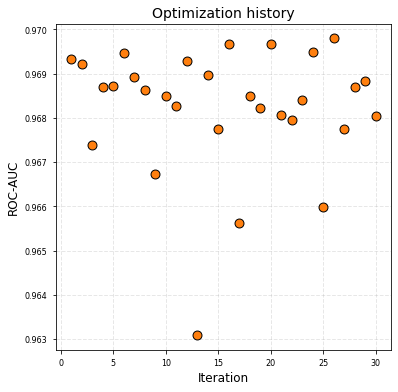

Train & and validate using the Following Parameters: 
 {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 255}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: Deprecation

In [ ]:
# # Init. model function for the objective function:
rf_clf = RandomForestClassifier()

# # Setting up number of evaluations and Trials object
n_evals = 30
rf_trails = Trials()


rf_search_space = {
        'max_features': "auto",
        'n_estimators': hp_scope.int(hp.quniform('n_estimators', 32,512,1)),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
        }

# # Running optimization
rf_tune = fmin(partial(objective_func, clf= rf_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=rf_search_space, algo=tpe.suggest,
                trials=rf_trails, max_evals=n_evals, rstate=rng)

# Output the optimization history
rf_optimization_df, rf_best_hp = optimization_trails(rf_trails,rf_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(rf_trails)
plt.show()

# Generate final scores
rf_scores, rf_scores_raw  = tunned_model_evaluation(clf=rf_clf,opt_hp=space_eval(rf_search_space,rf_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, rf_roc_data = generate_roc_data(rf_clf.set_params(**space_eval(rf_search_space,rf_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 31 
    Loss: -0.96768 
    using: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 401} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 32 
    Loss: -0.96685 
    using: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 427} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 33 
    Loss: -0.96602 
    using: {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 247} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 34 
    Loss: -0.96786 
    using: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 192} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
######################

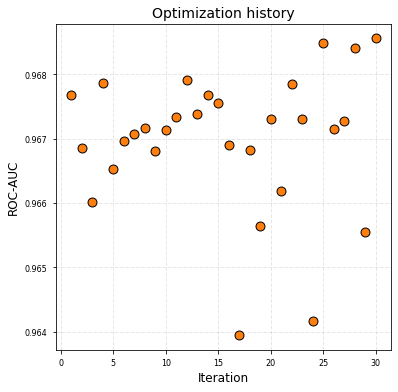

Train & and validate using the Following Parameters: 
 {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 204}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: Deprecation

In [ ]:
# # Init. model function for the objective function:
ext_clf = ExtraTreesClassifier()

# # Setting up number of evaluations and Trials object
n_evals = 30
ext_trails = Trials()

ext_search_space = {
        'max_features': "auto",
        'n_estimators': hp_scope.int(hp.quniform('n_estimators', 32,512,1)),
        'criterion': hp.choice('criterion', ["gini", "entropy"])
        }

# # Running optimization
ext_tune = fmin(partial(objective_func, clf= ext_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=ext_search_space, algo=tpe.suggest,
                trials=ext_trails, max_evals=n_evals, rstate=rng)

# Output the optimization history
ext_optimization_df, ext_best_hp = optimization_trails(ext_trails,ext_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(ext_trails)
plt.show()

# Generate final scores
ext_scores, ext_scores_raw  = tunned_model_evaluation(clf=ext_clf,opt_hp=space_eval(ext_search_space,ext_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, ext_roc_data = generate_roc_data(ext_clf.set_params(**space_eval(ext_search_space,ext_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)



#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 61 
    Loss: -0.87728 
    using: {'n_neighbors': 24, 'p': 1, 'weights': 'uniform'} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 62 
    Loss: -0.82413 
    using: {'n_neighbors': 25, 'p': 3, 'weights': 'uniform'} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 63 
    Loss: -0.89638 
    using: {'n_neighbors': 35, 'p': 4, 'weights': 'distance'} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 64 
    Loss: -0.83628 
    using: {'n_neighbors': 18, 'p': 5, 'weights': 'uniform'} 
#############################


#############################
 Results ƪ(˘⌣˘)ʃ 
#############################

    Iterations: 65 
    Loss: -0.83382 
    using: {'n_neighbors': 

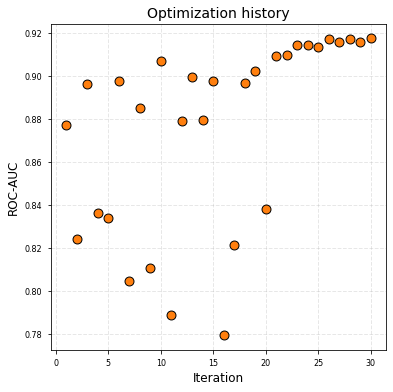

Train & and validate using the Following Parameters: 
 {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: Deprecation

In [ ]:
# Init. model function for the objective function:
knn_clf = KNeighborsClassifier()

# Setting up number of evaluations and Trials object
n_evals = 30
knn_trails = Trials()

knn_search_space =  {
        'n_neighbors': hp_scope.int(hp.quniform('knn_n_neighbors', 1, 50,1)),
        'p': hp_scope.int(hp.quniform('p', 1, 5,1)),
        'weights': hp.choice('weights', ["uniform","distance"])
        }

# Running optimization
knn_tune = fmin(partial(objective_func, clf= knn_clf, xdata=X_train_out, ydata=Y_train_out,cv_resample=inner_cv),
                space=knn_search_space, algo=tpe.suggest,
                trials=knn_trails, max_evals=n_evals, rstate=rng)

# Output the optimization history
knn_optimization_df, knn_best_hp = optimization_trails(knn_trails,knn_search_space)

# Plot optimization history of Random Forest
fig, ax = optimization_history(knn_trails)
plt.show()

# Generate final scores
knn_scores, knn_scores_raw = tunned_model_evaluation(clf=knn_clf,opt_hp=space_eval(knn_search_space,knn_tune),x=X_Data,y=Y_Data,cv=outer_cv,scores=score_metrics)

# Generate and Compute ROC curve
_, knn_roc_data = generate_roc_data(knn_clf.set_params(**space_eval(knn_search_space,knn_tune)),X_train_out,Y_train_out,X_test_out,Y_test_out)

In [ ]:
models_names_list = ['EXT','KNN','RF']
models_raw_scores_list = [
                          ext_scores_raw["test_AUC"],
                          knn_scores_raw["test_AUC"],
                          rf_scores_raw["test_AUC"]
                          ]

sig_df = sig_stat(models_raw_scores_list,models_names_list)
with open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/sig_test.md",'w') as tabl:
    print(tabulate(sig_df, headers=['Pairwise', 'p.value','t.value'],tablefmt="grid"),file=tabl)

EXT vs. KNN:
T: 1.880442096086239 	 p: 0.1091879886741341
EXT vs. RF:
T: 0.06753607949746505 	 p: 0.9478127613624301
KNN vs. RF:
T: -1.8430355344574059 	 p: 0.11544160578653853


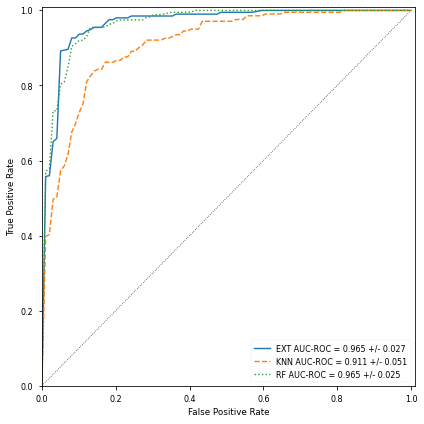

In [ ]:
models_roc_data_list = [
                          ext_roc_data,
                          knn_roc_data,
                          rf_roc_data
                          ]

fig, ax = plot_roc_curves(models_roc_data_list,models_names_list)
ax.set_xlim(0, 1.01)
ax.set_ylim(0, 1.01)

plt.legend(loc="best")
fig.tight_layout()
plt.show()
fig.savefig("/content/drive/MyDrive/FINAL_RESEARCH_DATA/ROC_plot1.jpg",dpi=600, quality=100,bbox_inchs="tight")

In [ ]:
# Output the Optimium parameters as md table
hyper_opt = pd.concat([rf_best_hp.T,knn_best_hp.T,ext_best_hp.T])
hyper_opt = pd.concat([
                        #   bart_best_hp.T,
                          ext_best_hp.T,
                          knn_best_hp.T,
                          rf_best_hp.T
                          ])

hyper_opt = hyper_opt.rename(columns={0: "optimium","0": "optimium"})
hyper_opt["hyperparamter"] = hyper_opt.index
hyper_opt = hyper_opt.round({"optimium":4})
with open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/hyper_opt.md",'w') as tabl:
    print(tabulate(hyper_opt, headers=['Hyperparamter', 'Optimium'],tablefmt="grid"),file=tabl)

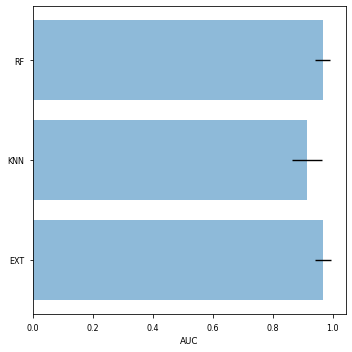

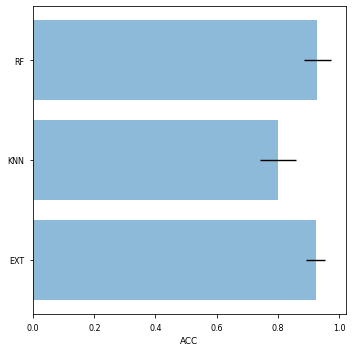

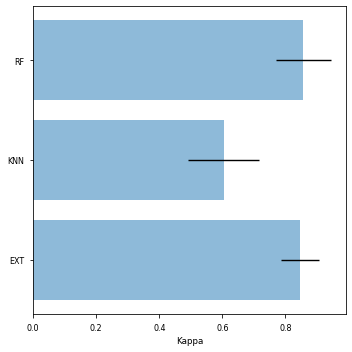

In [ ]:
# Output the scores results as md table
score_opt = pd.concat([
ext_scores.loc[["test_AUC","test_Accuracy","test_Kappa"],["mean","std"]].T,
knn_scores.loc[["test_AUC","test_Accuracy","test_Kappa"],["mean","std"]].T,
rf_scores.loc[["test_AUC","test_Accuracy","test_Kappa"],["mean","std"]].T
])
score_opt = score_opt.round({"test_AUC":3,"test_Accuracy":3,"test_Kappa":3})
with open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/score_opt.md",'w') as tabl:
    print(tabulate(score_opt, headers=['AUC', 'ACC','Kappa'],tablefmt="grid"),file=tabl)

# Build the plot
# Define labels, positions, bar heights and error bar heights
for idx, metric in enumerate(["AUC","ACC","Kappa"]):
    # models_names_list = ["RF","SVM","NB","KNN","DT","NNET","LGB"]
    y_pos = np.arange(len(models_names_list))
    ct = [score_opt.iloc[i,idx] for i in range(0,len(score_opt),2)]
    error = [score_opt.iloc[i,idx] for i in range(1,len(score_opt),2)]
    plt.style.use("seaborn-paper")
    fig, ax = plt.subplots(figsize=(5,5))
    ax.barh(y_pos,ct,
        xerr=error,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=10)
    ax.set_xlabel(metric)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models_names_list)
    # ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)

    # Save the figure and show
    fig.tight_layout()
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/FINAL_RESEARCH_DATA/'+metric+'.jpg',quality=100,dpi=300,bbox_inchs="tight")
    plt.show()

In [ ]:
st_data_grid = pd.read_hdf('./Data/Predict/Study_Area45_Array.hdf').iloc[:,0:16]
st_xy_grid = pd.read_hdf('./Data/Predict/Study_Area45_Array.hdf').values[:,-2:]
bins= [0.05,0.30,0.50,0.75,np.inf]
bins_labels=["Very Low", "Low", "Moderate", "High", "Very High"]
bins_labels_replace = {"0":"Very Low", "1":"Low", "2":"Moderate", "3":"High", "4":"Very High",
                        "0.0":"Very Low", "1.0":"Low", "2.0":"Moderate", "3.0":"High", "4.0":"Very High"}
_, prediction_data, prediction_summary = perform_prediction(clf=models_list,clf_names=models_names_list,\
train_data=[X_Data, Y_Data],predict_data=st_data_grid,\
bins=bins,bins_labels=bins_labels,XY=st_xy_grid,export_prediction=False,export_csv=True)
prediction_summary = prediction_summary.replace({"class":bins_labels_replace})

vrt_file = "./Output/Tables/prediction.vrt"
outputBounds,width, height = [305739,4054353,224105,4007733], 1632.68, 932.4
prediction_to_raster(clf_names=models_names_list,vrt_file=vrt_file,
                    layers="prediction",outputSRS="EPSG:32632",
                    outputBounds=outputBounds,width=width,height=height,noData=-9999)
sample_shp = "./Data/shp/Ls_Pts.shp"
rasters_list = ["./Output/Figures/" + model + ".tif" for model in models_names_list]
prediction_overly_summary = extract_rs_unique_values(sample_shp, rasters_list,models_names_list)
prediction_overly_summary = prediction_overly_summary.replace({"class":bins_labels_replace})

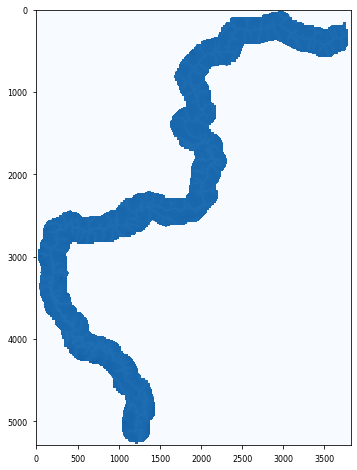

In [ ]:
m_result = rio.open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/RF.tif")
m_result_arr = m_result.read(2)
plt.rcParams['figure.figsize'] = [10, 8]
plt.imshow(m_result_arr, cmap="Blues", vmin=0, vmax=1)

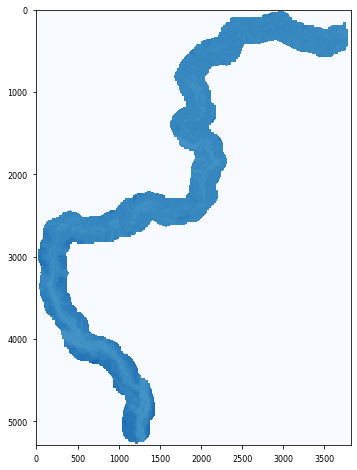

In [ ]:
m_result = rio.open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/EXT.tif")
m_result_arr = m_result.read(2)
plt.rcParams['figure.figsize'] = [10, 8]
plt.imshow(m_result_arr, cmap="Blues", vmin=0, vmax=1)

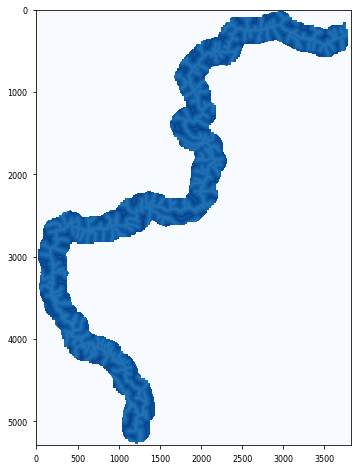

In [ ]:
m_result = rio.open("/content/drive/MyDrive/FINAL_RESEARCH_DATA/KNN.tif")
m_result_arr = m_result.read(2)
plt.rcParams['figure.figsize'] = [10, 8]
plt.imshow(m_result_arr, cmap="Blues", vmin=0, vmax=1)